In [1]:
import glob
import config
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [4]:
# training config:
epochs = 250
batch_size = 4

# define paths
import os
cwd = os. getcwd()
covid_path = cwd+'/dataset/covid_p'
noncovid_path = cwd+'/dataset/covid_n'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob.glob(covid_path + '/*')
noncovid_files = glob.glob(noncovid_path + '/*')


150 310


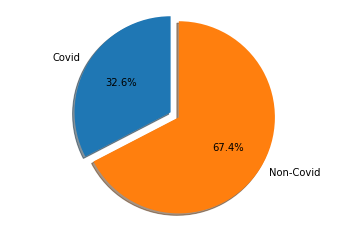

In [5]:
# 1st observation - Class Imbalance


print(len(covid_files), len(noncovid_files))

# Pie chart where the slices will be ordered and plotted counter-clockwise:
labels = 'Covid', 'Non-Covid'
sizes = [len(covid_files), len(noncovid_files)]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
# 2nd observation - Different Image sizes


A look at the dataset

In [30]:
from dataset import ImageFolder
#create train test split
train_ds = ImageFolder(root_dir="dataset/", transform = config.train_transforms)

class_weights=[1,2]
sample_weights = [0] * len(train_ds)
for idx, (data, label) in enumerate(train_ds):
    class_weight = class_weights[label]
    sample_weights[idx]=class_weights
# Sampler not used for the moment
#sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    
train_size = int(0.8 * len(train_ds))
test_size = len(train_ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_ds, [train_size, test_size])
train_dataset.transform = config.train_transforms
test_dataset.transform = config.val_transforms
print(train_dataset.transform)
print(len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS,pin_memory=config.PIN_MEMORY, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS,pin_memory=config.PIN_MEMORY,shuffle=True)


Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  RandomCrop(always_apply=False, p=1.0, height=224, width=224),
  Rotate(always_apply=False, p=0.5, limit=(-40, 40), interpolation=1, border_mode=4, value=None, mask_value=None),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.1),
  Normalize(always_apply=False, p=1.0, mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
92


In [ ]:
# 3rd observation (some are grayscaled and some are RGB)

Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: torch.Size([1])
Label: 0


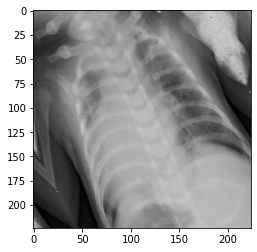

In [7]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]#.squeeze()
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
import torchvision.models as models
import torch.nn as nn
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

feature_extract=True
use_pretrained=True
model_ft = models.vgg11(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
input_size = 224

In [17]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if True:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [18]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [24]:
from train import train_model

num_epochs = 15
mloss = nn.CrossEntropyLoss(weight= torch.tensor(class_weights).type(torch.FloatTensor).to(device))

dataloaders = {"train": train_loader, "val": val_loader}
# Optimizer
#optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_ft.parameters(), lr=0.0005, weight_decay=0.1)
m, validaccuracy = train_model(model_ft, dataloaders, mloss, optimizer, device, num_epochs=num_epochs,is_inception=False)# decay=0.1, valid_interval=2, learning_rate=0.0001)

Epoch 0/14
----------
train Loss: 0.4847 Acc: 0.7908
val Loss: 0.3587 Acc: 0.7826

Epoch 1/14
----------
train Loss: 0.4171 Acc: 0.8125
val Loss: 0.3000 Acc: 0.8478

Epoch 2/14
----------
train Loss: 0.4253 Acc: 0.8125
val Loss: 0.3023 Acc: 0.9022

Epoch 3/14
----------
train Loss: 0.4084 Acc: 0.8207
val Loss: 0.2105 Acc: 0.9130

Epoch 4/14
----------
train Loss: 0.3911 Acc: 0.8370
val Loss: 0.2373 Acc: 0.9130

Epoch 5/14
----------
train Loss: 0.3453 Acc: 0.8451
val Loss: 0.2559 Acc: 0.9022

Epoch 6/14
----------
train Loss: 0.3750 Acc: 0.8288
val Loss: 0.2589 Acc: 0.8804

Epoch 7/14
----------
train Loss: 0.3536 Acc: 0.8424
val Loss: 0.2249 Acc: 0.9239

Epoch 8/14
----------
train Loss: 0.3229 Acc: 0.8777
val Loss: 0.2314 Acc: 0.8696

Epoch 9/14
----------
train Loss: 0.3333 Acc: 0.8505
val Loss: 0.4991 Acc: 0.8043

Epoch 10/14
----------
train Loss: 0.4112 Acc: 0.8179
val Loss: 0.2898 Acc: 0.8587

Epoch 11/14
----------
train Loss: 0.3915 Acc: 0.8179
val Loss: 0.2245 Acc: 0.9348

Ep

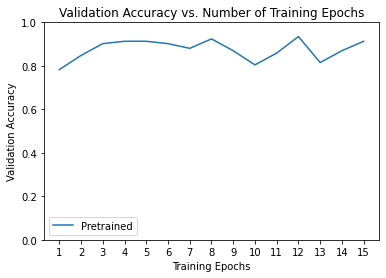

In [26]:
import numpy as np
ohist = []

ohist = [h.cpu().numpy() for h in validaccuracy]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [27]:
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [28]:

class_names = ["covid", "no covid"]
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

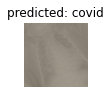

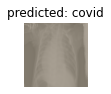

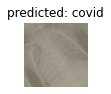

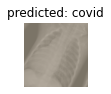

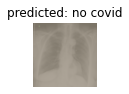

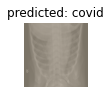

In [29]:
visualize_model(model_ft)

plt.ioff()
plt.show()